In [1]:
%matplotlib inline
%env OMP_NUM_THREADS=10 
%pylab inline 
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [12, 12]

import sys
import os
sys.path.append("../utils")

from utils_3d import *
from sfm import *

import copy

env: OMP_NUM_THREADS=10
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load data 

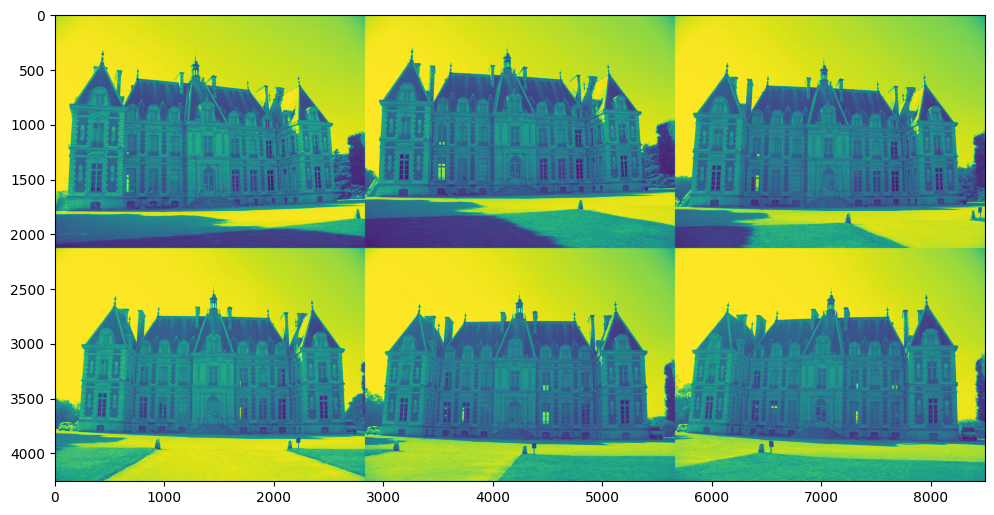

In [ ]:
# sample dataset directory
sample_data_path = "../ImageDataset_SceauxCastle/images/"

K = np.loadtxt(os.path.join(sample_data_path,"K.txt"))

# For calculation Essential Matrix
ims = []

fnames = ["100_7101.JPG","100_7102.JPG","100_7103.JPG","100_7104.JPG","100_7105.JPG","100_7106.JPG"]

for fname in fnames:
    ims.append(cv2.imread(os.path.join(sample_data_path,fname)))

sfm = Sfm(K,np.eye(3),np.zeros(3),ims)
imshow(np.vstack([np.hstack([sfm.views[0].im_gray,sfm.views[1].im_gray,sfm.views[2].im_gray]),
       np.hstack([sfm.views[3].im_gray,sfm.views[4].im_gray,sfm.views[5].im_gray])]))

# matching sift

In [3]:
# key point detect view0 and view1
sfm.detectKeyPoints(0)
sfm.detectKeyPoints(1)

In [4]:
# matching keypoint between view1 and view2
match_pair = sfm.matchingKeyPointsOf2views(0,1)
print(len(match_pair))
print(len(sfm.match_manage_table))

# compute essential matrix by ransac epipolar
sfm.solveEpipolarEqToGetEssentialMatrix(0,1)
print(len(sfm.match_manage_table))

Create New matching table
1540
1540
1540
1540


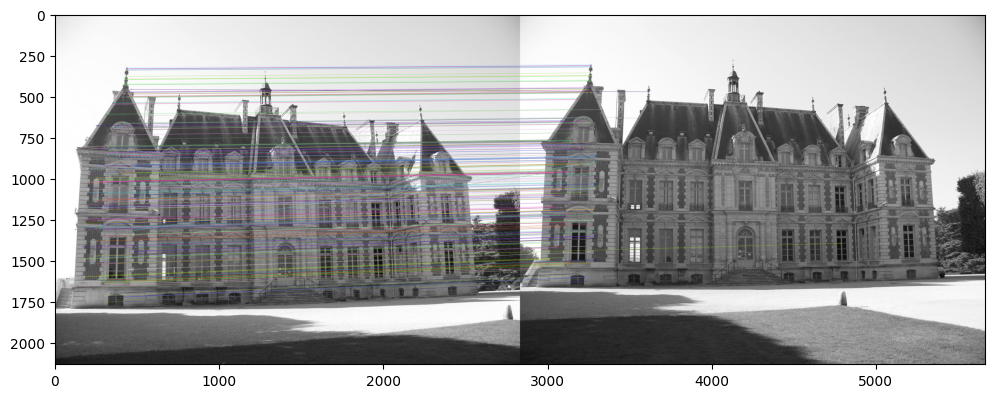

In [5]:
work = sfm
img_good_matches_inliers = cv2.drawMatches(work.views[0].im_gray,work.views[0].key_point_uvs,work.views[1].im_gray,work.views[1].key_point_uvs,match_pair[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

# Extract R ,t by Fundamental matrix and K
* F = K^(-T)EK^(-1)
* E = K^(T)FK
* E= [t]xR

In [6]:
w_v1Pv2,v2Rv1,v1Lmks,inlier_mask = sfm.decomposeE2Rt_and_calc_Xs_wrt_v1(0,1)

(1452, 2)
candidate idx:1
inlier mask len: (1452,)
match manage table shape: 1540


# view

[[ 0.99345581 -0.00924757 -0.11384213]
 [ 0.01271568  0.99947572  0.02977584]
 [ 0.11350709 -0.03102857  0.99305255]]
[ 0.97357414 -0.10439577 -0.20311308]


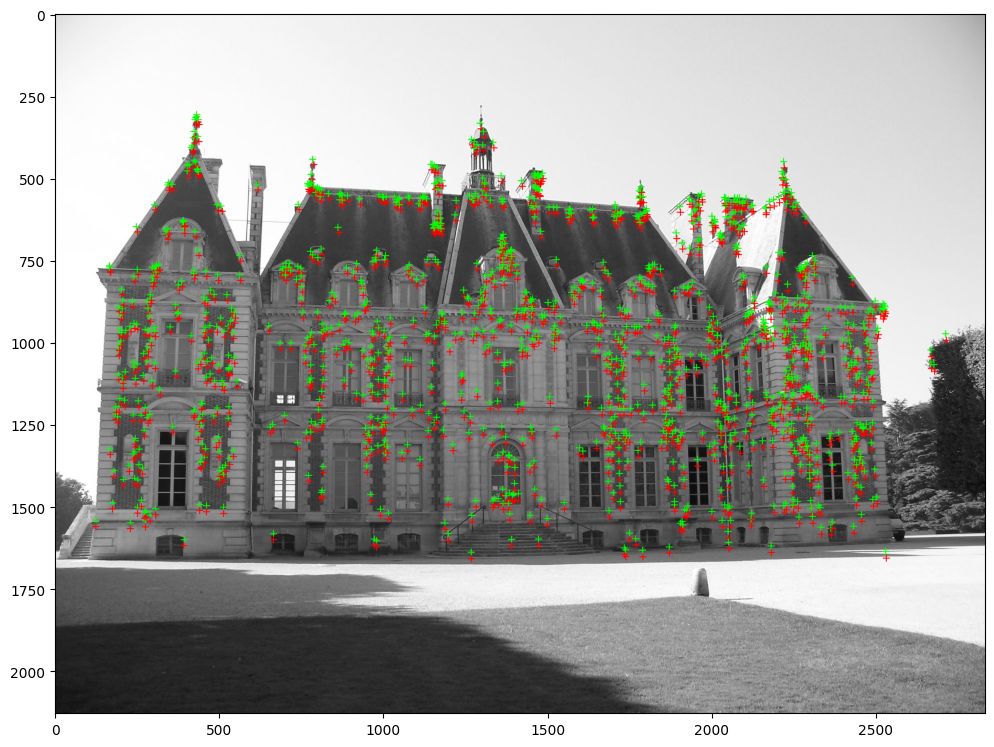

In [7]:
canvas = sfm.check_reprojected_points(1,verbose=False)
imshow(canvas)
print(sfm.views[1].R)
print(sfm.views[1].t)


# Third View PNP

In [8]:
# matching v1 and v2
for j in range(1,len(fnames)-1):
    print(j)
    sfm.detectKeyPoints(j+1)
    v2_v3_match_pair = sfm.matchingKeyPointsOf2views(j,j+1)
    wPv3,wRv3 = sfm.solvePNPToGet_v1Tv2(j,j+1)

1
New 1330 points are added.
[ 0.97357414 -0.10439577 -0.20311308]
[-1.52437906  0.11399273  0.42175918]
2
New 938 points are added.
[ 1.57970503 -0.08382099 -0.11005791]
[-2.40008     0.13790198  0.81329643]
3
New 900 points are added.
[ 2.53679939 -0.07061307  0.02268698]
[-3.13530385  0.1670156   0.99786067]
4
New 877 points are added.
[ 3.27812101 -0.01834634  0.32762237]
[-3.94270753  0.11405778  1.14281045]


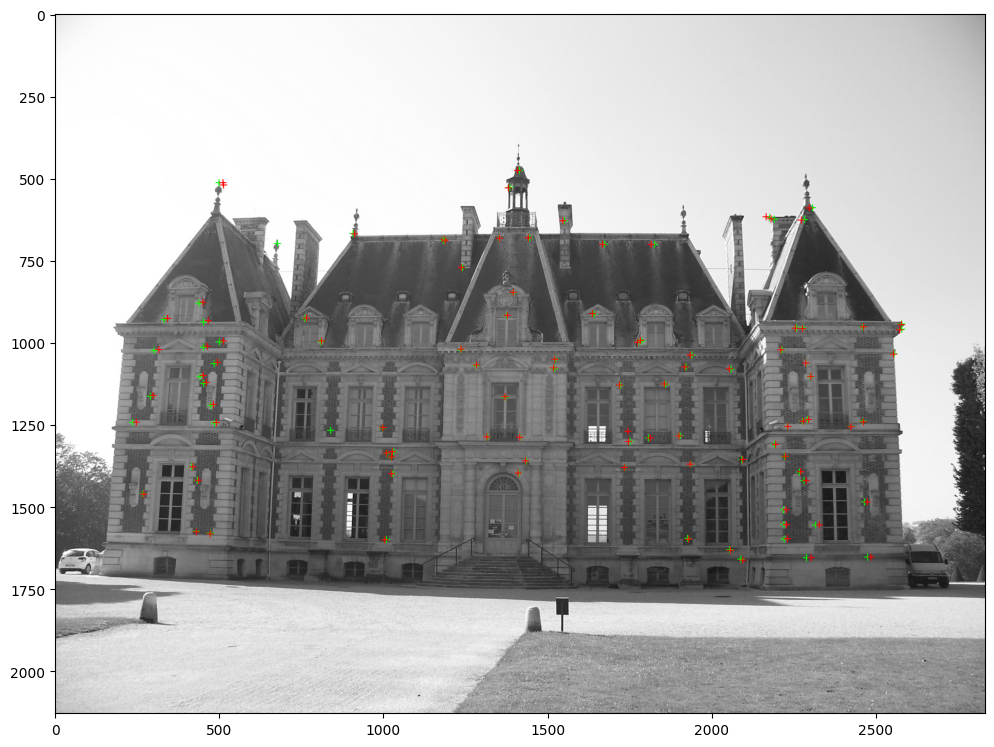

In [9]:
img_good_matches_inliers = cv2.drawMatches(sfm.views[1].im_gray,sfm.views[1].key_point_uvs,sfm.views[2].im_gray,sfm.views[2].key_point_uvs,v2_v3_match_pair[:200],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
imshow(img_good_matches_inliers)

canvas = sfm.check_reprojected_points(4)
imshow(canvas)

In [10]:
out_pcl_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test2.ply"
out_camera_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera2.ply"

pts2,wLmks,_ = sfm.get2D_3Dcoresspondance(1,2,True)
save_3dpoints_ply(wLmks,out_pcl_file_name,[255,0,0])

Rs = []
Ps = []
for i in range(sfm.numViews):
    R = sfm.views[i].R
    t = sfm.views[i].t
    Rs.append(R)
    Ps.append(t)

Rs = np.array(Rs)
Ps = np.array(Ps)

generate_multiple_camera_ply(Ps,Rs,out_camera_file_name,[0,255,0],False)

# BA

In [11]:
#sfm.BA = BundleAdjust(sfm.K)

In [12]:
sfm.make3viewGraphForBA()

(58, 3) 58 (6, 58, 2)
207.87758728325625 1175.055435680494 [ 210.97119141 1194.46435547]
265.02833866563446 1447.736912540077 [ 266.43450928 1468.46838379]
323.6233681102147 791.2358494604334 [327.08581543 809.72784424]
460.6112996429512 743.006042586436 [464.35690308 761.37658691]
463.5523753346713 1345.7408027052327 [ 465.90640259 1366.33935547]
488.7501634307393 1395.7383348691296 [ 490.01229858 1416.953125  ]
486.78396264645573 811.5308823287195 [490.37295532 830.50726318]
492.47085428063275 1584.7978918023339 [ 493.12350464 1606.36767578]
537.2126524442345 966.5234532569943 [540.04248047 986.7366333 ]
547.9635918377246 1185.0739737361623 [ 550.44763184 1205.76647949]
549.4468549837645 1589.8685552412499 [ 550.93719482 1611.27453613]
558.0034019796323 890.7376753122707 [561.34454346 910.47161865]
975.1485002975535 1220.1340947074714 [ 977.94085693 1240.92041016]
994.2969344223703 1305.2903427582055 [ 996.0680542  1326.43395996]
1009.362988825285 1318.7151294759258 [1011.00878906 13

In [13]:
sfm.optimizeBA(100)

Performing full BA:


iteration= 0	 chi2= 10511.630942	 time= 0.0005784	 cumTime= 0.0005784	 edges= 348	 schur= 1	 lambda= 877.471886	 levenbergIter= 1
iteration= 1	 chi2= 10332.712331	 time= 0.000204672	 cumTime= 0.000783072	 edges= 348	 schur= 1	 lambda= 292.490629	 levenbergIter= 1
iteration= 2	 chi2= 10269.513642	 time= 0.0001992	 cumTime= 0.000982272	 edges= 348	 schur= 1	 lambda= 97.496876	 levenbergIter= 1
iteration= 3	 chi2= 10206.853477	 time= 0.0001976	 cumTime= 0.00117987	 edges= 348	 schur= 1	 lambda= 32.498959	 levenbergIter= 1
iteration= 4	 chi2= 10128.235180	 time= 0.0001984	 cumTime= 0.00137827	 edges= 348	 schur= 1	 lambda= 10.832986	 levenbergIter= 1
iteration= 5	 chi2= 10009.108920	 time= 0.000195744	 cumTime= 0.00157402	 edges= 348	 schur= 1	 lambda= 3.610995	 levenbergIter= 1
iteration= 6	 chi2= 9821.019588	 time= 0.000195744	 cumTime= 0.00176976	 edges= 348	 schur= 1	 lambda= 1.203665	 levenbergIter= 1
iteration= 7	 chi2= 9553.067973	 time= 0.000194752	 cumTime= 0.00196451	 edges= 348	

In [14]:
sfm.updatePoseToResultOfBA()

In [15]:

Rs_ba = []
Ps_ba = []
for i in range(sfm.numViews):
    R = sfm.views[i].R
    t = sfm.views[i].t
    Rs_ba.append(R)
    Ps_ba.append(t)

Rs_ba = np.array(Rs_ba)
Ps_ba = np.array(Ps_ba)

_,lmks,_ = sfm.getAllviewCoresspondance(True)

(58, 3) 58 (6, 58, 2)


In [17]:
out_pcl_ba_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_test6_ba.ply"
out_camera_ba_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/camera6_ba.ply"

save_3dpoints_ply(lmks,out_pcl_ba_file_name,[100,100,155])
generate_multiple_camera_ply(Ps_ba,Rs_ba,out_camera_ba_file_name,[0,100,155],False)

In [18]:
wPxs_new = sfm.landmark_propagation(4,5)
out_pcl_prop_new_file_name = "/home/refsys/Desktop/sfm/viewer/webgl/static/model/old/model_prop_new.ply"
save_3dpoints_ply(wPxs_new,out_pcl_prop_new_file_name,[120,0,255])


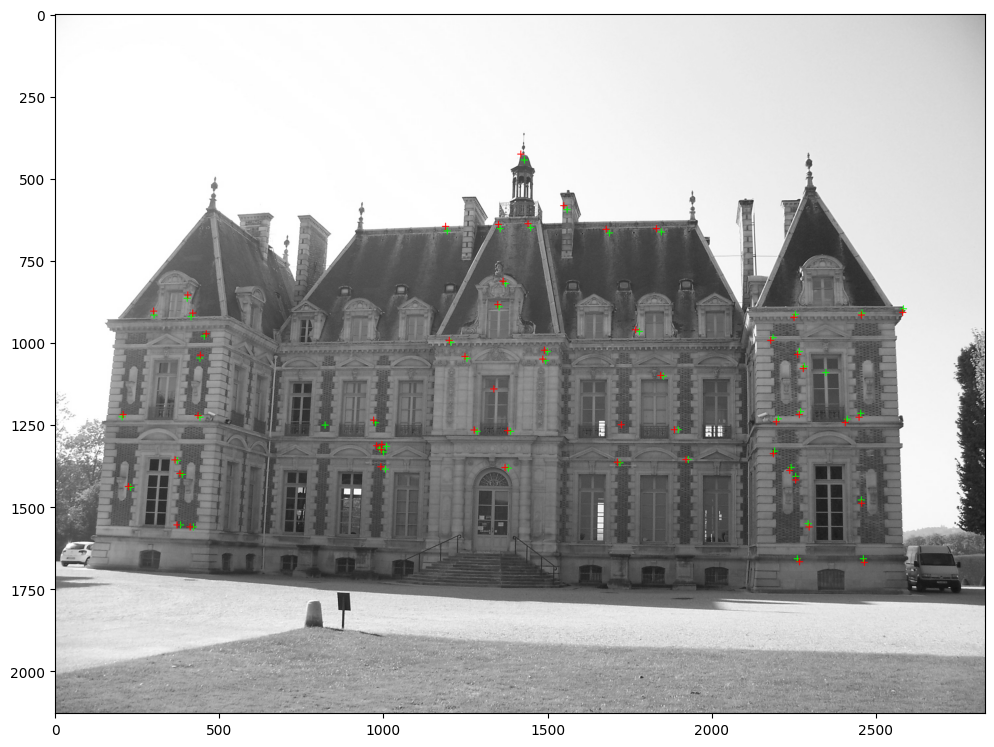

In [19]:
canvas = sfm.check_reprojected_points(5)
imshow(canvas)